In [2]:
import params as p
import datalib as dl
import matplotlib.pyplot as plt
import talib
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
# Inspired by:
# Machine Learning for Finance in Python
# https://campus.datacamp.com/courses/machine-learning-for-finance-in-python

# Preparing data and a linear model

## Explore the data with some EDA


**************** Loaded Config for ETHUSDNN ****************
*** Loading Data ***
Using loaded prices for 2019-03-07
            close  high     low    open   volume  volumeto       date
date                                                                 
2015-08-07   3.00  3.00  0.6747  0.6747   123.93    371.79 2015-08-07
2015-08-08   1.20  3.00  0.1500  3.0000  1942.89   1164.16 2015-08-08
2015-08-11   0.99  1.20  0.6504  1.2000  9234.57   7176.75 2015-08-11
2015-08-12   1.29  1.29  0.9050  0.9900  1736.11   1899.47 2015-08-12
2015-08-13   1.88  1.88  1.2600  1.2900  2815.45   4336.94 2015-08-13


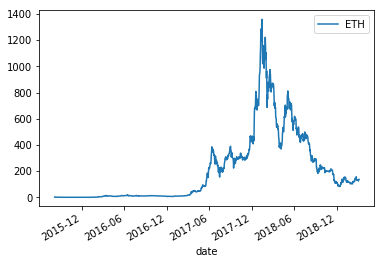

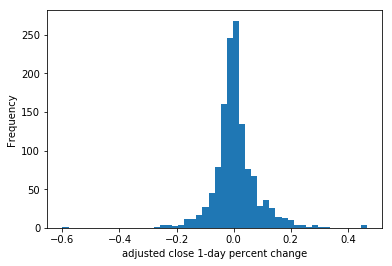

In [56]:
conf = 'ETHUSDNN'
p.load_config(conf)
ds = dl.load_price_data()
ds = ds[ds.volume > 0]
ds.index = ds.date

print(ds.head(5))  # examine the DataFrames

# Plot the close column for ETH
ds['close'].plot(label='ETH', legend=True)
plt.show()  # show the plot
plt.clf()  # clear the plot space

# Histogram of the daily price change percent of close for LNG
ds['close'].pct_change().plot.hist(bins=50)
plt.xlabel('adjusted close 1-day percent change')
plt.show()

## Correlations

                     1d_close_pct  1d_close_future_pct
1d_close_pct             1.000000            -0.033758
1d_close_future_pct     -0.033758             1.000000


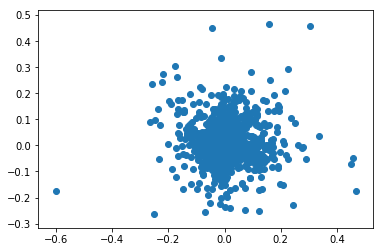

In [57]:
# Create 1-day % changes of close for the current day, and 1 day in the future
ds['1d_future_close'] = ds['close'].shift(-1)
ds['1d_close_future_pct'] = ds['1d_future_close'].pct_change()
ds['1d_close_pct'] = ds['close'].pct_change()

# Calculate the correlation matrix between the 1d close pecentage changes (current and future)
corr = ds[['1d_close_pct', '1d_close_future_pct']].corr()
print(corr)

# Scatter the current 1-day percent change vs the future 1-day percent change
plt.scatter(ds['1d_close_pct'], ds['1d_close_future_pct'])
plt.show()

## Create features

In [58]:
feature_names = ['1d_close_pct'] # a list of the feature names for later

# Create moving averages and rsi for timeperiods of 14, 30, 50, and 200
for n in [14, 30, 50, 100, 200]:
    # Create the moving average indicator and divide by close
    ds['ma' + str(n)] = talib.SMA(ds['close'].values,
                              timeperiod=n) / ds['close']
    # Create the RSI indicator
    ds['rsi' + str(n)] = talib.RSI(ds['close'].values, timeperiod=n)
    

    ds['vol'+ str(n)] = ds['volume']/ds['volume'].rolling(n).mean()
    ds['hh'+ str(n)] = ds['high']/ds['high'].rolling(n).max() 
    ds['ll'+ str(n)] = ds['low']/ds['low'].rolling(n).min()
    ds['std'+ str(n)]= ds['close'].rolling(n).std()/ds['close']
    ds['wr'+ str(n)] = talib.WILLR(ds['high'].values, ds['low'].values, ds['close'].values, n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma'+str(n),'rsi'+str(n),'vol'+str(n),'hh'+ str(n),'ll'+ str(n),'std'+str(n),'wr'+str(n)]
    
print(feature_names)

['1d_close_pct', 'ma14', 'rsi14', 'vol14', 'hh14', 'll14', 'std14', 'wr14', 'ma30', 'rsi30', 'vol30', 'hh30', 'll30', 'std30', 'wr30', 'ma50', 'rsi50', 'vol50', 'hh50', 'll50', 'std50', 'wr50', 'ma100', 'rsi100', 'vol100', 'hh100', 'll100', 'std100', 'wr100', 'ma200', 'rsi200', 'vol200', 'hh200', 'll200', 'std200', 'wr200']


In [59]:
# Create features and targets
# Drop all na values
ds = ds.dropna()

# Create features and targets
# use feature_names for features; 1d_close_future_pct for targets
features = ds[feature_names]
targets = ds['1d_close_future_pct']

# Create DataFrame from target column and feature columns
feat_targ_df = ds[['1d_close_future_pct'] + feature_names]

# Calculate correlation matrix
corr = feat_targ_df.corr()
print(corr)

                     1d_close_future_pct  1d_close_pct      ma14     rsi14  \
1d_close_future_pct             1.000000     -0.000821 -0.051579  0.103363   
1d_close_pct                   -0.000821      1.000000 -0.471592  0.378352   
ma14                           -0.051579     -0.471592  1.000000 -0.861238   
rsi14                           0.103363      0.378352 -0.861238  1.000000   
vol14                           0.050503     -0.002461  0.053174  0.010412   
hh14                            0.031196      0.216785 -0.785692  0.685901   
ll14                            0.114952      0.205343 -0.548534  0.575234   
std14                           0.074778     -0.034017  0.086021  0.039441   
wr14                            0.094392      0.443932 -0.846816  0.838383   
ma30                           -0.078415     -0.341974  0.878880 -0.934041   
rsi30                           0.107718      0.296692 -0.726699  0.936080   
vol30                           0.051515     -0.015028  0.079661

## Check the correlations

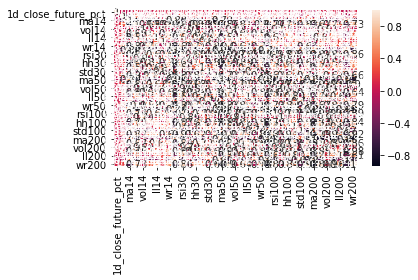

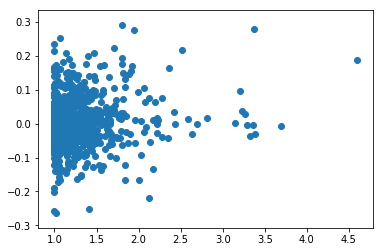

In [61]:
# Plot heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf()  # clear the plot area

# Create a scatter plot of the most highly correlated variable with the target
plt.scatter(ds['ll14'], ds['1d_close_future_pct'])
plt.show()

In [63]:
# Create train and test features

# Import the statsmodels.api library with the alias sm
import statsmodels.api as sm

# Add a constant to the features
linear_features = sm.add_constant(features)

# Create a size for the training set that is 85% of the total number of samples
train_size = int(0.85 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

(1100, 37) (935, 37) (165, 37)


                             OLS Regression Results                            
Dep. Variable:     1d_close_future_pct   R-squared:                       0.079
Model:                             OLS   Adj. R-squared:                  0.042
Method:                  Least Squares   F-statistic:                     2.132
Date:                 Thu, 07 Mar 2019   Prob (F-statistic):           0.000146
Time:                         22:59:21   Log-Likelihood:                 1269.1
No. Observations:                  935   AIC:                            -2464.
Df Residuals:                      898   BIC:                            -2285.
Df Model:                           36                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0858      0.167    

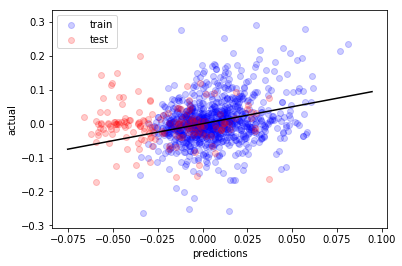

In [64]:
# Fit a linear model

# Create the linear model and complete the least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  # fit the model
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

# Evaluate our results

# Scatter the predictions vs the targets with 80% transparency
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

# Machine learning tree methods

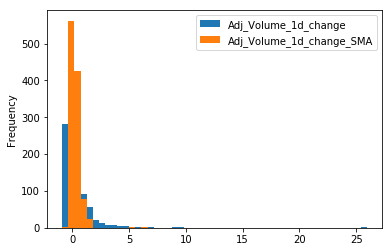

In [65]:
# Feature engineering from volume

# Create 2 new volume features, 1-day % change and 5-day SMA of the % change
new_features = ['Adj_Volume_1d_change', 'Adj_Volume_1d_change_SMA']
feature_names.extend(new_features)
ds['Adj_Volume_1d_change'] = ds['volume'].pct_change()
ds['Adj_Volume_1d_change_SMA'] = talib.SMA(ds['Adj_Volume_1d_change'].values, timeperiod=5)

# Plot histogram of volume % change data
ds[new_features].plot(kind='hist', sharex=False, bins=50)
plt.show()

In [66]:
# Create day-of-week features

# Use pandas' get_dummies function to get dummies for day of the week
days_of_week = pd.get_dummies(ds.index.dayofweek,
                              prefix='weekday',
                              drop_first=True)

# Set the index as the original dataframe index for merging
days_of_week.index = ds.index

# Join the dataframe with the days of week dataframe
ds = pd.concat([ds, days_of_week], axis=1)

# Add days of week to feature names
feature_names.extend(['weekday_' + str(i) for i in range(1, 7)])
ds.dropna(inplace=True)  # drop missing values in-place
print(ds.head())

            close   high   low   open     volume    volumeto       date  \
date                                                                      
2016-03-03   9.35   9.94  8.30   8.70   85546.90   800977.70 2016-03-03   
2016-03-04   9.96   9.96  8.27   9.35   91589.10   866953.71 2016-03-04   
2016-03-05  11.00  12.00  9.75   9.96  152475.01  1609872.81 2016-03-05   
2016-03-06  10.98  11.90  9.75  11.00   67041.65   728203.86 2016-03-06   
2016-03-07   9.50  11.47  9.06  10.98   66012.40   660786.54 2016-03-07   

            1d_future_close  1d_close_future_pct  1d_close_pct    ...      \
date                                                              ...       
2016-03-03             9.96             0.065241      0.074713    ...       
2016-03-04            11.00             0.104418      0.065241    ...       
2016-03-05            10.98            -0.001818      0.104418    ...       
2016-03-06             9.50            -0.134791     -0.001818    ...       
2016-03-07  

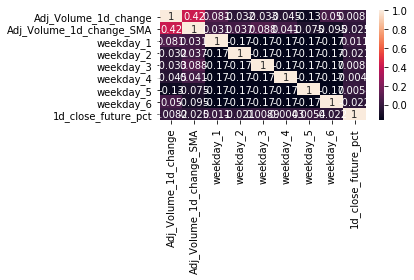

In [67]:
# Examine correlations of the new features

# Add the weekday labels to the new_features list
new_features.extend(['weekday_'+str(i) for i in range(1, 7)])

# Plot the correlations between the new features and the targets
sns.heatmap(ds[new_features + ['1d_close_future_pct']].corr(), annot=True)
plt.yticks(rotation=0)  # ensure y-axis ticklabels are horizontal
plt.xticks(rotation=90)  # ensure x-axis ticklabels are vertical
plt.tight_layout()
plt.show()

## Fit a decision tree

In [72]:
from sklearn.tree import DecisionTreeRegressor

# Create a decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Check the score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

0.9999991273523924
-2.1047847644997306


In [73]:
# Try different max depths

for d in [3, 5, 10]:
    # Create the tree and fit it
    decision_tree = DecisionTreeRegressor(max_depth=d)
    decision_tree.fit(train_features, train_targets)

    # Print out the scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features, train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

max_depth= 3
0.14483177326688068
-0.6383924996478618 

max_depth= 5
0.19388279238261252
-0.43735874409932674 

max_depth= 10
0.37632606573459526
-0.5739099659590288 



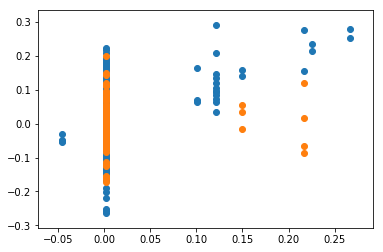

In [74]:
# Check our results

# Use the best max_depth of 3 from last exercise to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(train_features, train_targets)

# Predict values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.show()

## Fit a random forest

In [75]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.8607437094208178
-0.25585805941212514


In [76]:
# Tune random forest hyperparameters
from sklearn.model_selection import ParameterGrid

# Create a dictionary of hyperparameters to search
grid = {'n_estimators': [50, 100, 200], 'max_depth': [3, 4, 5], 'max_features': [2,4,8], 'random_state': [42]}
test_scores = []

# Loop through the parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is "unpacking" the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# Find best hyperparameters from the test score and print
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

-0.06474832744026293 {'random_state': 42, 'n_estimators': 200, 'max_features': 2, 'max_depth': 3}


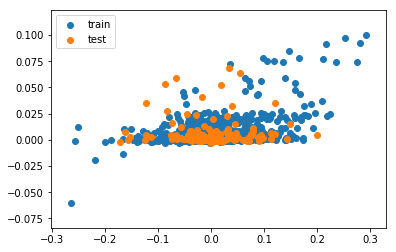

In [77]:
# Evaluate performance

# Use the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# Make predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Create a scatter plot with train and test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

## Random forest feature importances

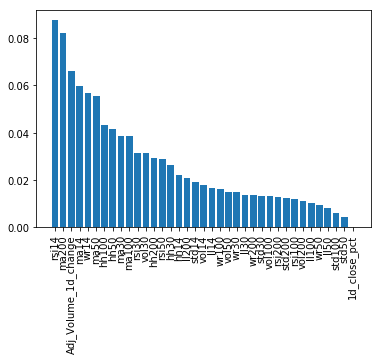

In [78]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

## A gradient boosting model

In [80]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.20934861229896895
-0.11181212217870984


## Gradient boosting feature importances

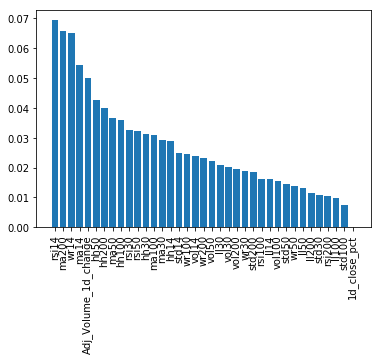

['rsi14' 'ma200' 'wr14' 'ma14' 'Adj_Volume_1d_change' 'hh50' 'hh200'
 'ma50' 'hh100' 'rsi30' 'rsi50' 'hh30' 'ma100' 'ma30' 'hh14' 'std14'
 'wr100' 'vol14' 'wr200' 'vol50' 'll30' 'vol30' 'vol200' 'wr30' 'std200'
 'rsi100' 'll14' 'vol100' 'std50' 'wr50' 'll50' 'll200' 'std30' 'rsi200'
 'll100' 'std100' '1d_close_pct']


In [101]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(len(feature_importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# Set the tick lables to be the feature names, according to the sorted feature_idx
plt.xticks(rotation=90)
plt.show()
print(labels)

# Neural networks and KNN

## Standardizing data

In [82]:
test_features.head()

,const,1d_close_pct,ma14,rsi14,vol14,hh14,ll14,std14,wr14,ma30,...,ll100,std100,wr100,ma200,rsi200,vol200,hh200,ll200,std200,wr200
date,,,,,,,,,,,,,,,,,,,,,
2018-09-23,1.0,0.017174,0.875174,51.605316,0.351485,0.973950,1.417966,0.083682,-12.429696,0.983083,...,1.417966,0.433174,-79.606538,1.943430,47.392400,0.679396,0.300000,1.417966,0.632238,-88.262168
2018-09-24,1.0,-0.067700,0.948457,46.271121,0.825779,0.962215,1.345047,0.088380,-31.057368,1.047168,...,1.345047,0.464881,-83.944570,2.074232,47.187429,1.630012,0.296386,1.345047,0.678871,-90.759001
2018-09-25,1.0,-0.039246,0.998285,43.645333,1.352977,0.892005,1.217978,0.082359,-41.124859,1.081581,...,1.217978,0.484467,-86.289097,2.147431,47.076835,2.748891,0.274759,1.217978,0.706603,-92.108437
2018-09-26,1.0,-0.023733,1.032866,42.148755,0.723415,0.872448,1.131749,0.069987,-57.473163,1.096308,...,1.241964,0.495361,-87.651281,2.188724,47.012496,1.415830,0.268735,1.241964,0.725340,-92.892467
2018-09-27,1.0,0.070921,0.969856,47.774863,0.970728,0.920363,1.094480,0.064916,-41.559862,1.013980,...,1.258036,0.459017,-83.504527,2.033081,47.223974,1.760018,0.283494,1.258036,0.676810,-90.605211


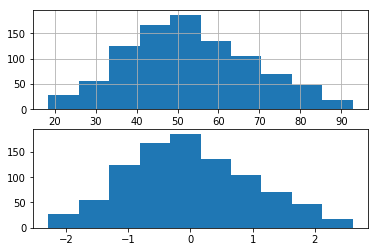

In [83]:
from sklearn.preprocessing import scale, StandardScaler

sc = StandardScaler()

# Standardize the train and test features
# scaled_train_features = scale(train_features)
# scaled_test_features = scale(test_features)

scaled_train_features = sc.fit_transform(train_features)
scaled_test_features = sc.transform(test_features)

# Plot histograms of the 14-day SMA RSI before and after scaling
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 3].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 3])
plt.show()

## Optimize n_neighbors

In [84]:
from sklearn.neighbors import KNeighborsRegressor

for n in range(2, 13):
    # Create and fit the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fit the model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # Print number of neighbors and the score to find the best value of n
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

n_neighbors = 2
train, test scores
0.554012785582844
-0.6226740908617112

n_neighbors = 3
train, test scores
0.41676348663748275
-0.4026776762059514

n_neighbors = 4
train, test scores
0.3685473332830512
-0.2969365258544405

n_neighbors = 5
train, test scores
0.32007777505259094
-0.19741387605213534

n_neighbors = 6
train, test scores
0.2682565704659228
-0.17193215292642905

n_neighbors = 7
train, test scores
0.2606230178804545
-0.12407870200278981

n_neighbors = 8
train, test scores
0.21741978282456553
-0.11506225788691138

n_neighbors = 9
train, test scores
0.1916666274530784
-0.07567175334725773

n_neighbors = 10
train, test scores
0.16737471156568784
-0.07809401083225942

n_neighbors = 11
train, test scores
0.15678930573856623
-0.07194087041378228

n_neighbors = 12
train, test scores
0.14456687943192326
-0.06994405907138312



## Evaluate KNN performance

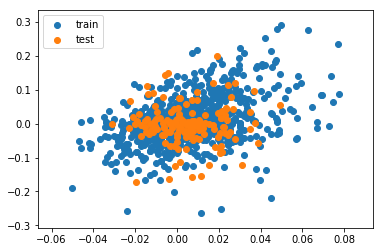

In [85]:
# Create the model with the best-performing n_neighbors of 5
knn = KNeighborsRegressor(n_neighbors=12)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# Get predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# Plot the actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.legend()
plt.show()

## Build and fit a simple neural net

In [86]:
from keras.models import Sequential
from keras.layers import Dense

# Create the model
model_1 = Sequential()
model_1.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_1.add(Dense(20, activation='relu'))
model_1.add(Dense(1, activation='linear'))

# Fit the model
model_1.compile(optimizer='adam', loss='mse')
history = model_1.fit(scaled_train_features, train_targets, epochs=25)

Epoch 1/25
935/935 [==============================] - 0s 341us/step - loss: 0.0343
Epoch 2/25
935/935 [==============================] - 0s 31us/step - loss: 0.0123
Epoch 3/25
935/935 [==============================] - 0s 31us/step - loss: 0.0080
Epoch 4/25
935/935 [==============================] - 0s 31us/step - loss: 0.0067
Epoch 5/25
935/935 [==============================] - 0s 31us/step - loss: 0.0059
Epoch 6/25
935/935 [==============================] - 0s 32us/step - loss: 0.0051
Epoch 7/25
935/935 [==============================] - 0s 32us/step - loss: 0.0048
Epoch 8/25
935/935 [==============================] - 0s 30us/step - loss: 0.0044
Epoch 9/25
935/935 [==============================] - 0s 30us/step - loss: 0.0041
Epoch 10/25
935/935 [==============================] - 0s 36us/step - loss: 0.0043
Epoch 11/25
935/935 [==============================] - 0s 31us/step - loss: 0.0039
Epoch 12/25
935/935 [==============================] - 0s 31us/step - loss: 0.0041
Epoch 13/25


## Plot losses

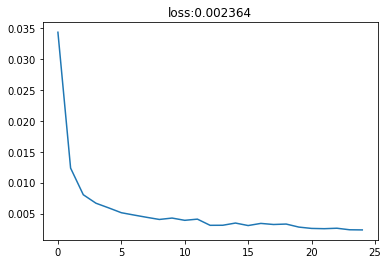

In [87]:
# Plot the losses from the fit
plt.plot(history.history['loss'])

# Use the last loss as the title
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

## Measure performance

0.5231200975354063
-2.0222985363358124


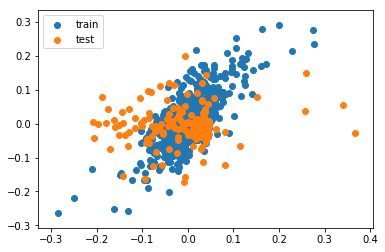

In [88]:
from sklearn.metrics import r2_score

# Calculate R^2 score
train_preds = model_1.predict(scaled_train_features)
test_preds = model_1.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Plot predictions vs actual
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend()
plt.show()

## Custom loss function

In [89]:
import keras.losses
import tensorflow as tf

# Create loss function
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))

    return tf.reduce_mean(loss, axis=-1)

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras
print(keras.losses.sign_penalty)

<function sign_penalty at 0x14775d510>


## Fit neural net with custom loss function

Epoch 1/25
935/935 [==============================] - 0s 369us/step - loss: 2.8240
Epoch 2/25
935/935 [==============================] - 0s 32us/step - loss: 0.7658
Epoch 3/25
935/935 [==============================] - 0s 33us/step - loss: 0.4195
Epoch 4/25
935/935 [==============================] - 0s 32us/step - loss: 0.3499
Epoch 5/25
935/935 [==============================] - 0s 33us/step - loss: 0.3167
Epoch 6/25
935/935 [==============================] - 0s 33us/step - loss: 0.2647
Epoch 7/25
935/935 [==============================] - 0s 30us/step - loss: 0.2208
Epoch 8/25
935/935 [==============================] - 0s 31us/step - loss: 0.2422
Epoch 9/25
935/935 [==============================] - 0s 30us/step - loss: 0.1989
Epoch 10/25
935/935 [==============================] - 0s 30us/step - loss: 0.1481
Epoch 11/25
935/935 [==============================] - 0s 30us/step - loss: 0.1533
Epoch 12/25
935/935 [==============================] - 0s 31us/step - loss: 0.1330
Epoch 13/25


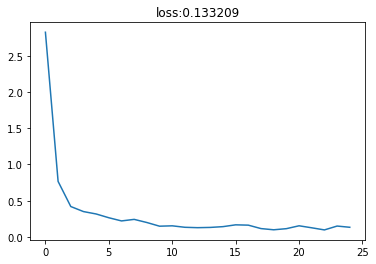

In [90]:
# Create the model
model_2 = Sequential()
model_2.add(Dense(100, input_dim=scaled_train_features.shape[1], activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

# Fit the model with our custom 'sign_penalty' loss function
model_2.compile(optimizer='adam', loss=sign_penalty)
history = model_2.fit(scaled_train_features, train_targets, epochs=25)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

## Visualize the results

0.19081071224309987
-2.342999383111397


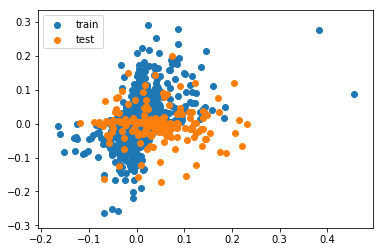

In [91]:
# Evaluate R^2 scores
train_preds = model_2.predict(scaled_train_features)
test_preds = model_2.predict(scaled_test_features)
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')  # plot test set
plt.legend(); plt.show()

## Combatting overfitting with dropout

Epoch 1/50
935/935 [==============================] - 1s 609us/step - loss: 0.1368
Epoch 2/50
935/935 [==============================] - 0s 42us/step - loss: 0.0617
Epoch 3/50
935/935 [==============================] - 0s 37us/step - loss: 0.0397
Epoch 4/50
935/935 [==============================] - 0s 37us/step - loss: 0.0331
Epoch 5/50
935/935 [==============================] - 0s 37us/step - loss: 0.0238
Epoch 6/50
935/935 [==============================] - 0s 35us/step - loss: 0.0238
Epoch 7/50
935/935 [==============================] - 0s 35us/step - loss: 0.0189
Epoch 8/50
935/935 [==============================] - 0s 34us/step - loss: 0.0153
Epoch 9/50
935/935 [==============================] - 0s 36us/step - loss: 0.0140
Epoch 10/50
935/935 [==============================] - 0s 33us/step - loss: 0.0129
Epoch 11/50
935/935 [==============================] - 0s 32us/step - loss: 0.0116
Epoch 12/50
935/935 [==============================] - 0s 38us/step - loss: 0.0098
Epoch 13/50


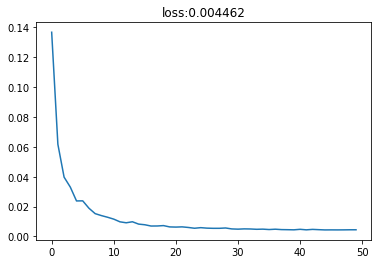

In [102]:
from keras.layers import Dropout

# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(20, input_dim=scaled_train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.2))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(scaled_train_features, train_targets, epochs=50)
plt.plot(history.history['loss'])
plt.title('loss:' + str(round(history.history['loss'][-1], 6)))
plt.show()

## Ensembling models

In [103]:
# Make predictions from the 3 neural net models
train_pred1 = model_1.predict(scaled_train_features)
test_pred1 = model_1.predict(scaled_test_features)

train_pred2 = model_2.predict(scaled_train_features)
test_pred2 = model_2.predict(scaled_test_features)

train_pred3 = model_3.predict(scaled_train_features)
test_pred3 = model_3.predict(scaled_test_features)

# Horizontally stack predictions and take the average across rows
train_preds = np.mean(np.hstack((train_pred1, train_pred2, train_pred3)), axis=1)
test_preds = np.mean(np.hstack((test_pred1, test_pred2, test_pred3)), axis=1)
print(test_preds[-5:])

[0.03303365 0.03248546 0.02628092 0.02157803 0.04430562]


## See how the ensemble performed

0.41251904080467194
-0.4326919438465968


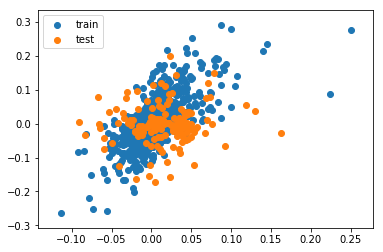

In [104]:
from sklearn.metrics import r2_score

# Evaluate the R^2 scores
print(r2_score(train_targets, train_preds))
print(r2_score(test_targets, test_preds))

# Scatter the predictions vs actual -- this one is interesting!
plt.scatter(train_preds, train_targets, label='train')
plt.scatter(test_preds, test_targets, label='test')
plt.legend(); plt.show()

# Machine learning with modern portfolio theory

## Join stock DataFrames and calculate returns

In [35]:
lng_df = pd.read_csv('./data/stocks/LNG.csv', usecols=[0,1], parse_dates=True, index_col=0)
lng_df = lng_df.rename(columns={'Adj_Close': 'LNG'})
print(lng_df.head())
spy_df = pd.read_csv('./data/stocks/SPY.csv', usecols=[0,1], parse_dates=True, index_col=0)
spy_df = spy_df.rename(columns={'Adj_Close': 'SPY'})
print(spy_df.head())
smlv_df = pd.read_csv('./data/stocks/SMLV.csv', usecols=[0,1], parse_dates=True, index_col=0)
smlv_df = smlv_df.rename(columns={'Adj_Close': 'SMLV'})
print(smlv_df.head())

              LNG
Date             
1994-04-04   72.0
1994-04-05  108.0
1994-04-06  108.0
1994-04-07  108.0
1994-04-08  108.0
                  SPY
Date                 
1993-01-29  28.223927
1993-02-01  28.424666
1993-02-02  28.484856
1993-02-03  28.785997
1993-02-04  28.906440
                 SMLV
Date                 
2013-02-21  49.482507
2013-02-22  49.881225
2013-02-25  49.440974
2013-02-26  49.200082
2013-02-27  49.424361


## Join stock DataFrames and calculate returns
Our first step towards calculating modern portfolio theory (MPT) portfolios is to get daily and monthly returns. Eventually we're going to get the best portfolios of each month based on the Sharpe ratio. The easiest way to do this is to put all our stock prices into one DataFrame, then to resample them to the daily and monthly time frames. We need daily price changes to calculate volatility, which we will use as our measure of risk.

In [36]:
# Join 3 stock dataframes together
full_df = pd.concat([lng_df, spy_df, smlv_df], axis=1).dropna()
print(full_df.head())

# Resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()

# Calculate daily returns of stocks
returns_daily = full_df.pct_change()

# Calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()
print(returns_monthly.tail())

              LNG         SPY       SMLV
Date                                    
2013-02-21  20.21  139.802535  49.482507
2013-02-22  20.99  141.168775  49.881225
2013-02-25  20.44  138.482768  49.440974
2013-02-26  21.15  139.430774  49.200082
2013-02-27  21.57  141.187368  49.424361
                 LNG       SPY      SMLV
Date                                    
2017-12-01  0.019558  0.027069  0.029058
2018-01-01  0.128300  0.021450 -0.010725
2018-02-01  0.057770  0.047662 -0.003823
2018-03-01 -0.103353 -0.049293 -0.048131
2018-04-02  0.021396 -0.034367  0.009406


## Calculate covariances for volatility
In MPT, we quantify risk via volatility. The math for calculating portfolio volatility is complex, and it requires daily returns covariances. We'll now loop through each month in the returns_monthly DataFrame, and calculate the covariance of the daily returns.

With pandas datetime indices, we can access the month and year with df.index.month and df.index.year. We'll use this to create a mask for returns_daily that gives us the daily returns for the current month and year in the loop. We then use the mask to subset the DataFrame like this: df[mask]. This gets entries in the returns_daily DataFrame which are in the current month and year in each cycle of the loop. Finally, we'll use pandas' .cov() method to get the covariance of daily returns.

In [37]:
# Daily covariance of stocks (for each monthly period)
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:    
    # Mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    
    # Use the mask to get daily returns for the current month and year of monthy returns index
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])

           LNG       SPY      SMLV
LNG   0.000366  0.000192  0.000146
SPY   0.000192  0.000173  0.000127
SMLV  0.000146  0.000127  0.000103


## Calculate portfolios
We'll now generate portfolios to find each month's best one. numpy's random.random() generates random numbers from a uniform distribution, then we normalize them so they sum to 1 using the /= operator. We use these weights to calculate returns and volatility. Returns are sums of weights times individual returns. Volatility is more complex, and involves the covariances of the different stocks.

Finally we'll store the values in dictionaries for later use, with months' dates as keys.

In this case, we will only generate 10 portfolios for each date so the code will run faster, but in a real-world use-case you'd want to use more like 1000 to 5000 randomly-generated portfolios for a few stocks.

In [40]:
portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

# Get portfolio performances at each month
for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(5000):
        weights = np.random.random(3)
        weights /= np.sum(weights) # /= divides weights by their sum to normalize
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)
        
print(portfolio_weights[date][0])

[0.24569793 0.33390854 0.42039353]


## Plot efficient frontier
We can finally plot the results of our MPT portfolios, which shows the "efficient frontier". This is a plot of the volatility vs the returns. This can help us visualize our risk-return possibilities for portfolios. The upper left boundary of the points is the best we can do (highest return for a given risk), and that is the efficient frontier.

To create this plot, we will use the latest date in our covariances dictionary which we created a few exercises ago. This has dates as keys, so we'll get the sorted keys using sorted() and .keys(), then get the last entry with Python indexing ([-1]). Lastly we'll use matplotlib to scatter variance vs returns and see the efficient frontier for the latest date in the data.

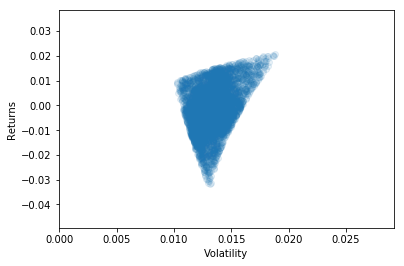

In [41]:
# Get latest date of available data
date = sorted(covariances.keys())[-1]  

# Plot efficient frontier
# warning: this can take at least 10s for the plot to execute...
plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date],  alpha=0.1)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

## Get best Sharpe ratios
We need to find the "ideal" portfolios for each date so we can use them as targets for machine learning. We'll loop through each date in portfolio_returns, then loop through the portfolios we generated with portfolio_returns[date]. We'll then calculate the Sharpe ratio, which is the return divided by volatility (assuming a no-risk return of 0).

We use enumerate() to loop through the returns for the current date (portfolio_returns[date]) and keep track of the index with i. Then we use the current date and current index to get the volatility of each portfolio with portfolio_volatility[date][i]. Finally, we get the index of the best Sharpe ratio for each date using np.argmax(). We'll use this index to get the ideal portfolio weights soon.

In [44]:
# Empty dictionaries for sharpe ratios and best sharpe indexes by date
sharpe_ratio, max_sharpe_idxs = {}, {}

# Loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
    
        # Divide returns by the volatility for the date and index, i
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i])

    # Get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

print(portfolio_returns[date][max_sharpe_idxs[date]])

0.017941070484482714


## Calculate EWMAs
We will now work towards creating some features to be able to predict our ideal portfolios. We will simply use the price movement as a feature for now. To do this we will create a daily exponentially-weighted moving average (EWMA), then resample that to the monthly timeframe. Finally, we'll shift the monthly moving average of price one month in the future, so we can use it as a feature for predicting future portfolios.

In [45]:
# Calculate exponentially-weighted moving average of daily returns
ewma_daily = returns_daily.ewm(span=30).mean()

# Resample daily returns to first business day of the month with average for that month
ewma_monthly = ewma_daily.resample('BMS').first()

# Shift ewma for the month by 1 month forward so we can use it as a feature for future predictions 
ewma_monthly = ewma_monthly.shift(1).dropna()

print(ewma_monthly.iloc[-1])

LNG    -0.004304
SPY    -0.001003
SMLV   -0.001670
Name: 2018-04-02 00:00:00, dtype: float64


## Make features and targets
To use machine learning to pick the best portfolio, we need to generate features and targets. Our features were just created in the last exercise – the exponentially weighted moving averages of prices. Our targets will be the best portfolios we found from the highest Sharpe ratio.

We will use pandas' .iterrows() method to get the index, value pairs for the ewma_monthly DataFrame. We'll set the current value of ewma_monthly in the loop to be our features. Then we'll use the index of the best Sharpe ratio (from max_sharpe_idxs) to get the best portfolio_weights for each month and set that as a target.

In [46]:
targets, features = [], []

# Create features from price history and targets as ideal portfolio
for date, ewma in ewma_monthly.iterrows():

    # Get the index of the best sharpe ratio
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewma)  # add ewma to features

targets = np.array(targets)
features = np.array(features)
print(targets[-5:])

[[3.10754290e-02 9.53079327e-01 1.58452443e-02]
 [8.73694133e-01 1.24366696e-01 1.93917088e-03]
 [3.56411025e-01 6.41517442e-01 2.07153325e-03]
 [6.62119538e-03 9.83576321e-01 9.80248317e-03]
 [7.12233335e-01 9.50234426e-05 2.87671642e-01]]


## Plot efficient frontier with best Sharpe ratio
Let's now plot the efficient frontier again, but add a marker for the portfolio with the best Sharpe index. Visualizing our data is always a good idea to better understand it.

Recall the efficient frontier is plotted in a scatter plot of portfolio volatility on the x-axis, and portfolio returns on the y-axis. We'll get the latest date we have in our data from covariances.keys(), although any of the portfolio_returns, etc, dictionaries could be used as well to get the date. Then we get volatilities and returns for the latest date we have from our portfolio_volatility and portfolio_returns. Finally we get the index of the portfolio with the best Sharpe index from max_sharpe_idxs[date], and plot everything with plt.scatter().

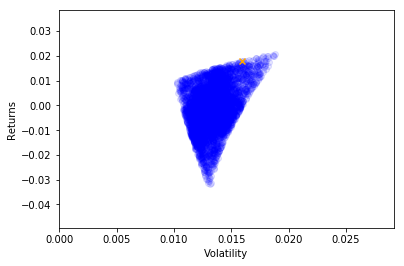

In [47]:
# Get most recent (current) returns and volatility
date = sorted(covariances.keys())[-1]
cur_returns = portfolio_returns[date]
cur_volatility = portfolio_volatility[date]

# Plot efficient frontier with sharpe as point
plt.scatter(x=cur_volatility, y=cur_returns, alpha=0.1, color='blue')
best_idx = max_sharpe_idxs[date]

# Place an orange "X" on the point with the best Sharpe ratio
plt.scatter(x=cur_volatility[best_idx], y=cur_returns[best_idx], marker='x', color='orange')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

## Make predictions with a random forest
In order to fit a machine learning model to predict ideal portfolios, we need to create train and test sets for evaluating performance. We will do this as we did in previous chapters, where we take our features and targets arrays, and split them based on a train_size we set. Often the train size may be around 70-90% of our data.

We then fit our model (a random forest in this case) to the training data, and evaluate the R2 scores on train and test using .score() from our model. In this case, the hyperparameters have been set for you, but usually you'd want to do a search with ParameterGrid like we did in previous chapters.

In [49]:
from sklearn.ensemble import RandomForestRegressor
# Make train and test features
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

# Fit the model and check scores on train and test
rfr = RandomForestRegressor(n_estimators=300, random_state=42)
rfr.fit(train_features, train_targets)
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.8238317208603032
-0.4579982958574606


## Get predictions and first evaluation
Now that we have a trained random forest model (rfr), we want to use it to get predictions on the test set. We do this to evaluate our model's performance – at a basic level, is it doing as well or better than just buying the index, SPY?

We'll use the typical sklearn .predict(features) method, then multiply our monthly returns by our portfolio predictions. We sum these up with np.sum() since this will have 3 rows for each month. Then we plot both the monthly returns from our predictions, as well as SPY and compare the two.

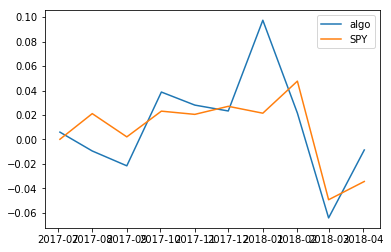

In [50]:
# Get predictions from model on train and test
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Calculate and plot returns from our RF predictions and the SPY returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='algo')
plt.plot(returns_monthly['SPY'].iloc[train_size:], label='SPY')
plt.legend()
plt.show()

## Evaluate returns
Let's now see how our portfolio selection would perform as compared with just investing in the SPY. We'll do this to see if our predictions are promising, despite the low R2 value.

We will set a starting value for our investment of $1000, then loop through the returns from our predictions as well as from SPY. We'll use the monthly returns from our portfolio selection and SPY and apply them to our starting cash balance. From this we will get a month-by-month picture of how our investment is doing, and we can see how our predictions did overall vs the SPY. Next, we can plot our portfolio from our predictions and compare it to SPY.

In [51]:
# Calculate the effect of our portfolio selection on a hypothetical $1k investment
cash = 1000
algo_cash, spy_cash = [cash], [cash]  # set equal starting cash amounts
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)

# Calculate performance for SPY
cash = 1000  # reset cash amount
for r in returns_monthly['SPY'].iloc[train_size:]:
    cash *= 1 + r
    spy_cash.append(cash)

print('algo returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])
print('SPY returns:', (spy_cash[-1] - spy_cash[0]) / spy_cash[0])

algo returns: 0.10812811316358784
SPY returns: 0.07811831329855999


## Plot returns
Lastly, we'll plot the performance of our machine-learning-generated portfolio versus just holding the SPY. We can use this as an evaluation to see if our predictions are doing well or not.

Since we already have algo_cash and spy_cash created, all we need to do is provide them to plt.plot() to display. We'll also set the label for the datasets with legend in plt.plot().

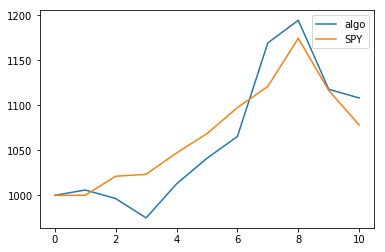

In [52]:
# Plot the algo_cash and spy_cash to compare overall returns
plt.plot(algo_cash, label='algo')
plt.plot(spy_cash, label='SPY')
plt.legend()  # show the legend
plt.show()